# Time Series Forecasting with Neural Network Model: S&P 500 index

## Goal: Predict Open / Close Price of the date
* To assist traders to make decision
* Make feature of interest as a function input: can easily be converted to predict High and Low price of the day

## Steps
* Get data: Get data from yahoo finance (last 5 years)


* EDA: Visualization. Missing Data? Outliers?


* Train/Test/Evaluation data split (80% / 10% / 10%)
* Feature Engineering: MinMaxScaler to "Train Data Only"
* Feature Engineering: Conver data to sequential format (to feed them to the LSTM model)


* Model Evaluation: Get MAE, RMS from the test data set --> This is the predicted performance of this model.
* See if the model works as predicted with evaluation data.

In [1]:
import pandas_datareader as pdr
from datetime import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Import S&P 500 index from Yahoo Finance
df=pdr.get_data_yahoo('^GSPC', )

In [3]:
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2017-08-01,2478.510010,2471.139893,2477.100098,2476.350098,3460860000,2476.350098
2017-08-02,2480.379883,2466.479980,2480.379883,2477.570068,3478580000,2477.570068
2017-08-03,2476.030029,2468.850098,2476.030029,2472.159912,3645020000,2472.159912
2017-08-04,2480.000000,2472.080078,2476.879883,2476.830078,3235140000,2476.830078
2017-08-07,2480.949951,2475.879883,2477.139893,2480.909912,2931780000,2480.909912


# Feature definitions
* Date: Date of interest
* High: Highest index within the day
* Low : Lowest index within the day
* Close: Closing index of the date
* Volume: How many shares have traded within the day
* Adj Close: Closing price after adjustments for all applicable splits and dividend distributions

In [4]:
len(df[df['Close']!=df['Adj Close']])

0

In [5]:
# Drop the Adj Close column because it is the same as the Close column
df = df.drop('Adj Close',axis=1)

In [6]:
df.head()

,High,Low,Open,Close,Volume
Date,,,,,
2017-08-01,2478.510010,2471.139893,2477.100098,2476.350098,3460860000
2017-08-02,2480.379883,2466.479980,2480.379883,2477.570068,3478580000
2017-08-03,2476.030029,2468.850098,2476.030029,2472.159912,3645020000
2017-08-04,2480.000000,2472.080078,2476.879883,2476.830078,3235140000
2017-08-07,2480.949951,2475.879883,2477.139893,2480.909912,2931780000


In [7]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
High,1258.0,3.352941e+03,6.981184e+02,2300.729980,2.783108e+03,3.064565e+03,3.959122e+03,4.818620e+03
Low,1258.0,3.312843e+03,6.893792e+02,2191.860107,2.752705e+03,3.006700e+03,3.910830e+03,4.780040e+03
Open,1258.0,3.333886e+03,6.939144e+02,2290.709961,2.773932e+03,3.039260e+03,3.929133e+03,4.804510e+03
Close,1258.0,3.334164e+03,6.940668e+02,2237.399902,2.767615e+03,3.037225e+03,3.935092e+03,4.796560e+03
Volume,1258.0,3.907596e+09,1.078591e+09,0.000000,3.257680e+09,3.642305e+09,4.236952e+09,9.878040e+09


# Exploratory Data Analysis and Feature Engineering

## EDA
* Check for missing data
* Visualize

In [8]:
df.isnull().sum()

High      0
Low       0
Open      0
Close     0
Volume    0
dtype: int64

Text(0.5, 1.0, 'S&P 500 Index Open Price')

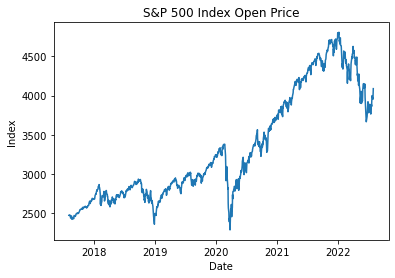

In [9]:
plt.figure()
plt.plot(df['Open'],color='tab:blue')
plt.xlabel('Date')
plt.ylabel('Index')
plt.title('S&P 500 Index Open Price')

Text(0.5, 1.0, 'S&P 500 Index Close Price')

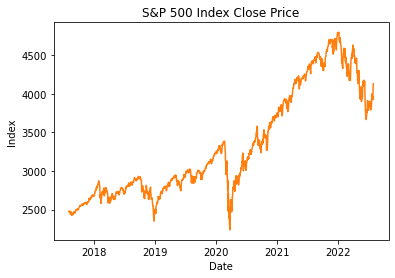

In [10]:
plt.figure()
plt.plot(df['Close'],color='tab:orange')
plt.xlabel('Date')
plt.ylabel('Index')
plt.title('S&P 500 Index Close Price')

Text(0.5, 1.0, 'Absolute value of Close Price - Open Price')

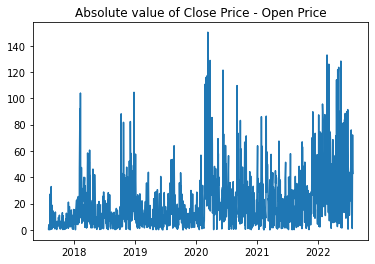

In [11]:
plt.figure()
plt.plot(abs(df['Close']-df['Open']))
plt.title('Absolute value of Close Price - Open Price')

In [12]:
(df['Close']-df['Open']).abs().mean()

21.846104268618344

In [13]:
(df['Close']-df['Open']).abs().std()

23.659842293851874

## Feature Engineering
* Take Open and Close prices from the dataset


* Scale the data: MinMaxScaler
* Take first 80% for training set
* Take the most recent 30 days for evaluation set
* Left over: test set


* Convert data to a model-feedable form
* Model: Use LSTM. (Advanced version of RNN; specialized in predict future value based on past data)
* Predict the price based on past 30 days: Feed 2D tensor to each date (overall data format will be 3D tensor; date x 30days x features)

### Why MinMax over Standard scaler?
* The price value itself is more relevant than the distribution (Z-score)

## Reference
* I found Colah's post is very helpful for understanding how LSTM performs. I HIGHLY recommend checking this post http://colah.github.io/posts/2015-08-Understanding-LSTMs/

In [14]:
# Define a function that reframe data (include past 30 days data)
def make_sequential_data(X,features,num_timesteps):
    """
    Take data X, len_days (number of past days to make a model out of)
    i-th date: data should be 2-D tensor for a day. len_days rows
    The overall data will be (date x num_timesteps x num_features) 3-D tensor
    """
    data=[]
    y=[]
    Y = X[features]
    Y = np.array(Y)
    X = np.array(X)
    for i in range(num_timesteps, len(X)): # range: start point inclusive, end point exclusive (i=30 ~ len(X)-1)
        data.append(X[i-num_timesteps:i]) # -30 days to current date, 5 features
        y.append(Y[i])
    return np.array(data), np.array(y)

## Scale and Split data (80% training, 10% test, last 10 % for evaluation)
* Make a temporal test data set just to get the statistics to scale the data: prevent leakage from future information
* Check the shape of the re-framed dataset: (num_data, num_timestepts=30, num_features=2)

In [15]:
X_train = df[:int(0.8*len(df))]
len(X_train)

1006

In [16]:
from sklearn.preprocessing import MinMaxScaler

In [17]:
scaler = MinMaxScaler()
scaler.fit(X_train)
# scaler for X_train is enough for scaling purpose, but want to inverse transform the predicted price afterwards.
# Generate scaler for price inverse transform
scaler2 = MinMaxScaler()
scaler2.fit(X_train[['Open', 'Close']])

MinMaxScaler()

In [18]:
scaled_data = scaler.transform(df)
scaled_data = pd.DataFrame(data=scaled_data, index=df.index, columns=df.columns)
scaled_data.describe()

,High,Low,Open,Close,Volume
count,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000
mean,0.494172,0.506409,0.490752,0.501974,0.304266
std,0.327872,0.311430,0.326445,0.317665,0.125688
min,0.000000,0.000000,0.000000,0.000000,-0.151085
25%,0.226549,0.253364,0.227327,0.242673,0.228531
50%,0.358736,0.368108,0.352148,0.366069,0.273351
75%,0.778866,0.776553,0.770779,0.777012,0.342646
max,1.182530,1.169223,1.182592,1.171294,1.000000


In [19]:
scaled_X, scaled_y = make_sequential_data(scaled_data, features = ['Open', 'Close'], num_timesteps=30)

In [20]:
print(len(df), len(scaled_X))
print(scaled_X.shape, scaled_y.shape)

1258 1228
(1228, 30, 5) (1228, 2)


In [21]:
# Should have 30 fewer datapoints because first 30 rows were removed from the make_sequential function
scaled_X_train = scaled_X[:round(0.8*len(scaled_X))]
scaled_y_train = scaled_y[:round(0.8*len(scaled_X))]
print(scaled_X_train.shape, scaled_y_train.shape)

(982, 30, 5) (982, 2)


In [22]:
scaled_X_test = scaled_X[-round(0.2*len(scaled_X)):-round(0.1*len(scaled_X))]
scaled_y_test = scaled_y[-round(0.2*len(scaled_X)):-round(0.1*len(scaled_X))]
print(scaled_X_test.shape, scaled_y_test.shape)

(123, 30, 5) (123, 2)


In [23]:
scaled_X_eval = scaled_X[-round(0.1*len(scaled_X)):]
scaled_y_eval = scaled_y[-round(0.1*len(scaled_X)):]
print(scaled_X_eval.shape, scaled_y_eval.shape)

(123, 30, 5) (123, 2)


In [24]:
# Check data loss: sum should be 1228
982+123+123

1228

## Model & Prediction

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error

### Open Price prediction model
* Single LSTM layer model
* Double LSTM layer model
* Test under variant cell number

#### Reference: input data shape
https://stackoverflow.com/questions/61153831/how-to-properly-set-the-input-shape-of-lstm-layers

In [26]:
def single_layer_model(scaled_X_train, scaled_X_test, scaled_y_train, scaled_y_test, num_cells, epochs):
    model = Sequential()
    # Input shape should be (num_timesteps, num_features)
    model.add(LSTM(units=num_cells, activation='tanh', input_shape=scaled_X_train[0].shape)) 
    model.add(Dense(2)) # Return two values: "Open" and "Close"
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    # Early stop condition: no improve for next 10 points
    early_stop = EarlyStopping(monitor="val_loss", patience=10)
    model.fit(scaled_X_train, scaled_y_train, epochs=epochs, 
              validation_data=(scaled_X_test, scaled_y_test),
              callbacks=[early_stop], verbose=0)
    
    plt.figure()
    plt.title(f"Single Layer LSTM with {num_cells} cells")
    plt.plot(model.history.history['loss'], label='Train Loss')
    plt.plot(model.history.history['val_loss'], label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    plt.legend()
    
    return model

In [27]:
def model_evaluation(model, scaled_X_test, scaled_y_test, scaler2, num_cells):
    """
    Evaluate the Model with Test set
    """
    plt.figure()
    scaled_y_pred_test = model.predict(scaled_X_test, verbose=0)
    y_test = scaler2.inverse_transform(scaled_y_test)
    y_pred_test = scaler2.inverse_transform(scaled_y_pred_test)
    
    plt.plot(df.index[-round(0.2*len(scaled_X)):-round(0.1*len(scaled_X))],y_test[:,0],color='tab:blue', label="Real Open Price")
    plt.plot(df.index[-round(0.2*len(scaled_X)):-round(0.1*len(scaled_X))],y_test[:,1],color='tab:orange', label="Real Close Price")
    plt.plot(df.index[-round(0.2*len(scaled_X)):-round(0.1*len(scaled_X))],y_pred_test[:,0],color='tab:blue',linestyle='--', label="Predicted Open Price")
    plt.plot(df.index[-round(0.2*len(scaled_X)):-round(0.1*len(scaled_X))],y_pred_test[:,1],color='tab:orange',linestyle='--', label="Predicted Close Price")
    plt.xticks(rotation=90)
    plt.xlabel('Date')
    plt.ylabel('Index')
    plt.title(f'S&P 500 Index Price predicted with {num_cells} LSTM cells')
    plt.legend()
    
    print(f'====== {num_cells} cells LSTM Model ======')
    print(f'Mean Real Open Price: {y_test[:,0].mean().round(2)}')
    print(f'Mean Predicted Open Price: {y_pred_test[:,0].mean().round(2)}')
    print(f'MAE Open: {round(mean_absolute_error(y_test[:,0],y_pred_test[:,0]),2)}')
    print(f'RMS Open: {round(mean_squared_error(y_test[:,0],y_pred_test[:,0])**0.5,2)}')
    print("")
    print(f'Mean Real Close Price: {y_test[:,1].mean().round(2)}')
    print(f'Mean Predicted Close Price: {y_pred_test[:,1].mean().round(2)}')
    print(f'MAE Close: {round(mean_absolute_error(y_test[:,1],y_pred_test[:,1]),2)}')
    print(f'RMS Close: {round(mean_squared_error(y_test[:,1],y_pred_test[:,1])**0.5,2)}')
    print('')
    
    plt.figure()
    plt.title("Real-Prediction PDF")
    sns.kdeplot(y_test[:,0]-y_pred_test[:,0], color='tab:blue', label="Open Price")
    sns.kdeplot(y_test[:,1]-y_pred_test[:,1], color='tab:orange', label="Close Price")
    plt.legend()

====== 32 cells LSTM Model ======
Mean Real Open Price: 4552.15
Mean Predicted Open Price: 4535.7998046875
MAE Open: 33.76
RMS Open: 41.74

Mean Real Close Price: 4551.41
Mean Predicted Close Price: 4516.0400390625
MAE Close: 57.99
RMS Close: 69.0

====== 64 cells LSTM Model ======
Mean Real Open Price: 4552.15
Mean Predicted Open Price: 4522.5498046875
MAE Open: 32.51
RMS Open: 38.37

Mean Real Close Price: 4551.41
Mean Predicted Close Price: 4508.0498046875
MAE Close: 52.58
RMS Close: 62.8

====== 128 cells LSTM Model ======
Mean Real Open Price: 4552.15
Mean Predicted Open Price: 4529.77978515625
MAE Open: 27.78
RMS Open: 32.0

Mean Real Close Price: 4551.41
Mean Predicted Close Price: 4544.83984375
MAE Close: 35.79
RMS Close: 44.75



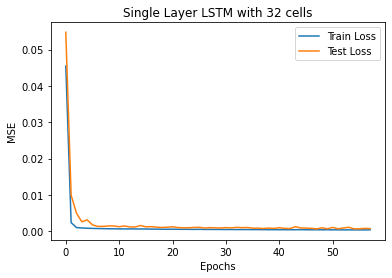

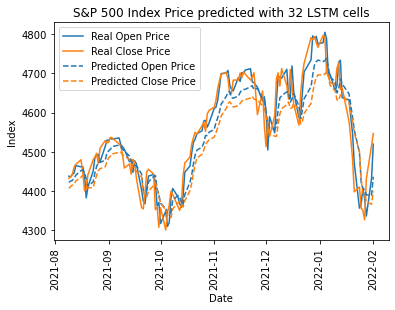

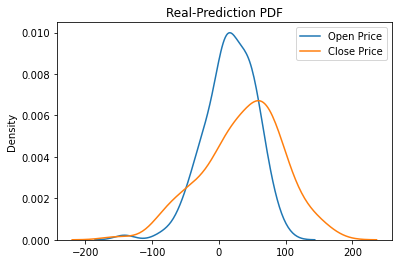

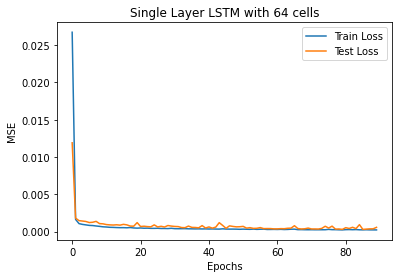

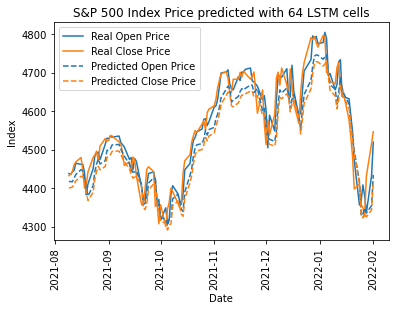

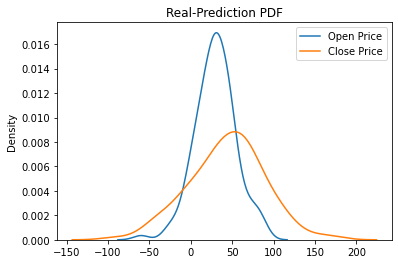

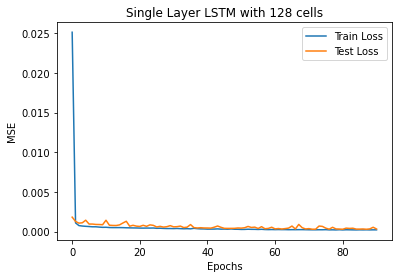

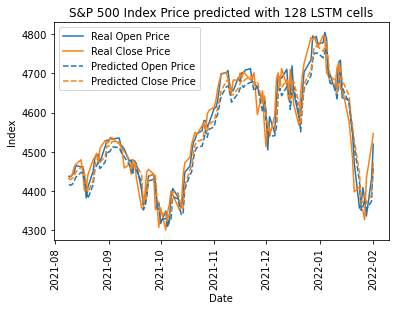

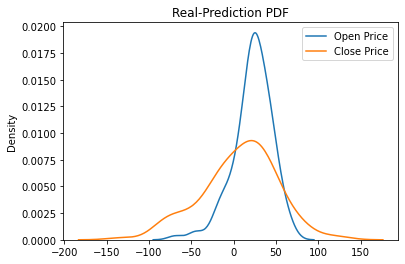

In [28]:
for num_cells in [32, 64,128]:
    model = single_layer_model(scaled_X_train, scaled_X_test, scaled_y_train, scaled_y_test, num_cells, epochs=100)
    model_evaluation(model, scaled_X_test, scaled_y_test, scaler2, num_cells)

# Evaluation
* There is no big difference between n= 32, 64, and 128 models
* Choose model with 128 cells

* Retrain the model with train + test data
* Evaluate the model with evaluation set

In [29]:
scaled_X_train = scaled_X[:round(0.9*len(scaled_X))]
scaled_y_train = scaled_y[:round(0.9*len(scaled_X))]
print(scaled_X_train.shape, scaled_y_train.shape)

(1105, 30, 5) (1105, 2)


In [30]:
model = Sequential()
model.add(LSTM(units=128, activation='tanh', input_shape=scaled_X_train[0].shape)) 
model.add(Dense(2)) # Return two values: "Open" and "Close"
model.compile(optimizer='adam', loss='mean_squared_error')

epochs=100
early_stop = EarlyStopping(monitor="val_loss", patience=10)
model.fit(scaled_X_train, scaled_y_train, epochs=epochs,
          validation_data=(scaled_X_eval, scaled_y_eval),
          callbacks=[early_stop], verbose=0)

====== 128 cells LSTM Model ======
Mean Real Open Price: 4175.97
Mean Predicted Open Price: 4191.41015625
MAE Open: 27.01
RMS Open: 35.13

Mean Real Close Price: 4174.98
Mean Predicted Close Price: 4210.740234375
MAE Close: 64.78
RMS Close: 79.85



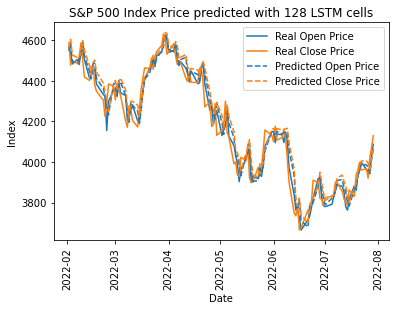

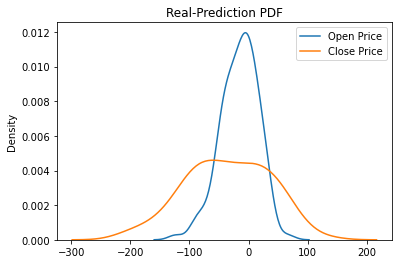

In [33]:
plt.figure()
scaled_y_pred_eval = model.predict(scaled_X_eval, verbose=0)
y_eval = scaler2.inverse_transform(scaled_y_eval)
y_pred_eval = scaler2.inverse_transform(scaled_y_pred_eval)

plt.plot(df.index[-round(0.1*len(scaled_X)):],y_eval[:,0],color='tab:blue', label="Real Open Price")
plt.plot(df.index[-round(0.1*len(scaled_X)):],y_eval[:,1],color='tab:orange', label="Real Close Price")
plt.plot(df.index[-round(0.1*len(scaled_X)):],y_pred_eval[:,0],color='tab:blue',linestyle='--', label="Predicted Open Price")
plt.plot(df.index[-round(0.1*len(scaled_X)):],y_pred_eval[:,1],color='tab:orange',linestyle='--', label="Predicted Close Price")
plt.xticks(rotation=90)
plt.xlabel('Date')
plt.ylabel('Index')
plt.title(f'S&P 500 Index Price predicted with {num_cells} LSTM cells')
plt.legend()
    
print('====== 128 cells LSTM Model ======')
print(f'Mean Real Open Price: {y_eval[:,0].mean().round(2)}')
print(f'Mean Predicted Open Price: {y_pred_eval[:,0].mean().round(2)}')
print(f'MAE Open: {round(mean_absolute_error(y_eval[:,0],y_pred_eval[:,0]),2)}')
print(f'RMS Open: {round(mean_squared_error(y_eval[:,0],y_pred_eval[:,0])**0.5,2)}')
print("")
print(f'Mean Real Close Price: {y_eval[:,1].mean().round(2)}')
print(f'Mean Predicted Close Price: {y_pred_eval[:,1].mean().round(2)}')
print(f'MAE Close: {round(mean_absolute_error(y_eval[:,1],y_pred_eval[:,1]),2)}')
print(f'RMS Close: {round(mean_squared_error(y_eval[:,1],y_pred_eval[:,1])**0.5,2)}')
print('')

plt.figure()
plt.title("Real-Prediction PDF")
sns.kdeplot(y_eval[:,0]-y_pred_eval[:,0], color='tab:blue', label="Open Price")
sns.kdeplot(y_eval[:,1]-y_pred_eval[:,1], color='tab:orange', label="Close Price")
plt.legend()

# Conclusion

### Model Evaluation

From train/test data, about 30 USD Open and 45 USD Close prices RMS expected. Given that the mean of the real price values are ~$4500, the predictions are quite accurate.

I tested models with 32, 64, and 128 LSTM cells. None of them underwent overfitting (No exploding test loss). A model with 128 cells was chosen.

The model is retrained with Train+Test data and deployed. The model is evaluated with "unseen" evaluation data. The model predicted the open price as expected from the train/test evaluation. Close price are less predictable and higher error were observed.

====== 128 cells LSTM Model (Train/Test) ======
* Mean Real Open Price: 4552.15
* Mean Predicted Open Price: 4529.77978515625
* MAE Open: 27.78
* RMS Open: 32.0


* Mean Real Close Price: 4551.41
* Mean Predicted Close Price: 4544.83984375
* MAE Close: 35.79
* RMS Close: 44.75

====== 128 cells LSTM Model (Evaluation set)======
* Mean Real Open Price: 4175.97
* Mean Predicted Open Price: 4191.41015625
* MAE Open: 27.01
* RMS Open: 35.13


* Mean Real Close Price: 4174.98
* Mean Predicted Close Price: 4210.740234375
* MAE Close: 64.78
* RMS Close: 79.85|

### Probability Density Function of Prediction - Real prices

Probability Density function of Predicted - Real price can be a good estimator for a decision making based on the model. With the RMS provided, we can realize how odd the open price is, by calculating Z-score (or p-value).

As explained above, the PDF of the open price of the upcoming month is similar to the model prediction. Close price is less predictable, so decisions based 

The image below will be provided:
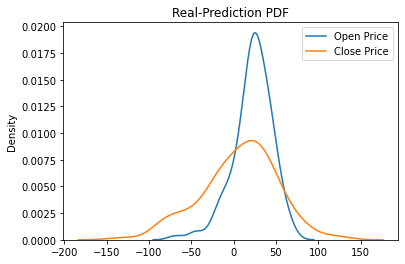

The real distribution of the upcoming month:
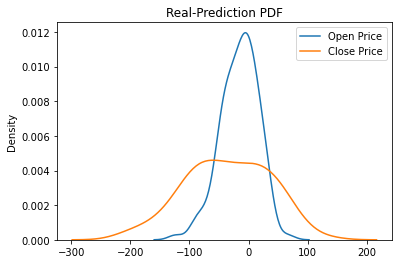